# Анализ данных о вакансиях с использованием методов машинного обучения

1. Подготовка данных

    1.1 Импорт библиотек

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

    1.2 Загрузка и предобработка данных

In [66]:
# Загрузка данных
data = pd.read_csv('Raw_Jobs.csv', on_bad_lines='skip', encoding='utf-8', sep=";")

# Предобработка данных
data.dropna(subset=['title'], inplace=True)
data['key_skills'] = data['key_skills'].fillna('Unknown')
data['location'] = data['location'].fillna('Unknown')

# Фильтрация релевантных вакансий
job_filter = data['title'].str.contains(
    'Analyst|Programmist|Python|Аналитик|программист|Data Science|ML|МЛ|специалист по данным|ML-engineer|Data Scientist|Machine Learning', 
    case=False, regex=True
)
filtered_data = data[job_filter]
filtered_data = filtered_data[filtered_data['salary'] != 'з/п не указана']

# Выбор релевантных столбцов
selected_columns = ['title', 'salary', 'experience', 'job_type', 'key_skills', 'location']
cleaned_data = filtered_data[selected_columns]

# Обработка зарплаты
def process_salary(salary):
    if pd.isna(salary):
        return np.nan
    if 'RUR' in salary:
        multiplier = 1
    elif 'USD' in salary:
        multiplier = 93
    elif 'EUR' in salary:
        multiplier = 104
    else:
        return np.nan
    
    salary = salary.replace(' RUR', '').replace(' USD', '').replace(' EUR', '')
    
    if 'до' in salary and 'от' in salary:
        salary_range = salary.replace('от ', '').replace('до', '-').split('-')
        return ((int(salary_range[0]) + int(salary_range[1])) / 2) * multiplier
    elif 'от' in salary:
        return int(salary.replace('от ', '')) * multiplier
    elif 'до' in salary:
        return int(salary.replace('до ', '')) * multiplier
    return np.nan

cleaned_data['salary'] = cleaned_data['salary'].apply(process_salary)

# Удаление строк с NaN значениями зарплаты
cleaned_data = cleaned_data.dropna(subset=['salary'])

# Обработка опыта работы
experience_mapping = {
    'Нет опыта': 0,
    'От 1 года до 3 лет': 2,
    'От 3 до 6 лет': 5,
    'Более 6 лет': 7
}
cleaned_data['experience'] = cleaned_data['experience'].map(experience_mapping)

# Вывод информации о данных
print("Форма очищенных данных:", cleaned_data.shape)
print("Первые несколько строк столбца 'key_skills':")
print(cleaned_data['key_skills'].head())
print("Количество уникальных значений в 'key_skills':", cleaned_data['key_skills'].nunique())
print("Количество NaN значений в столбце salary:", cleaned_data['salary'].isna().sum())

Форма очищенных данных: (6911, 6)
Первые несколько строк столбца 'key_skills':
301    Разработка технических заданий,SQL,BPMN,UML,Fi...
401    1С: Зарплата и управление персоналом,1С: Бухга...
460    Грамотная речь,Аналитическое мышление,Грамотно...
651    CRM,BPMN,Битрикс24,Битрикс 24,Моделирование би...
788    Английский язык,Ведение деловой переписки,Анал...
Name: key_skills, dtype: object
Количество уникальных значений в 'key_skills': 3963
Количество NaN значений в столбце salary: 0


C:\Users\ricar\AppData\Local\Temp\ipykernel_4604\851210774.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['salary'] = cleaned_data['salary'].apply(process_salary)


In [67]:
cleaned_data.head()

,title,salary,experience,job_type,key_skills,location
301,Системный аналитик IT,135000.0,5,"Полная занятость,удаленная работа","Разработка технических заданий,SQL,BPMN,UML,Fi...","Пермь, Петропавловская улица, 59А"
401,Ведущий 1С Аналитик,120000.0,2,"Полная занятость,удаленная работа","1С: Зарплата и управление персоналом,1С: Бухга...",Unknown
460,Аналитик - исследователь в медицинской сфере,90000.0,2,"Полная занятость,гибкий график","Грамотная речь,Аналитическое мышление,Грамотно...",Unknown
651,Специалист по настройке Битрикс24 (внедренец-а...,75000.0,2,"Полная занятость,полный день","CRM,BPMN,Битрикс24,Битрикс 24,Моделирование би...",Unknown
788,Маркетолог – аналитик,40000.0,2,"Полная занятость,полный день","Английский язык,Ведение деловой переписки,Анал...",Unknown


2. Анализ данных

    2.1 Общая статистика

In [68]:
print(cleaned_data.describe())

             salary   experience
count  6.911000e+03  6911.000000
mean   9.342553e+04     2.101577
std    1.609090e+05     1.860733
min    1.150000e+02     0.000000
25%    4.500000e+04     0.000000
50%    7.000000e+04     2.000000
75%    1.161250e+05     2.000000
max    1.200000e+07     7.000000


    2.2 Визуализация распределения зарплат

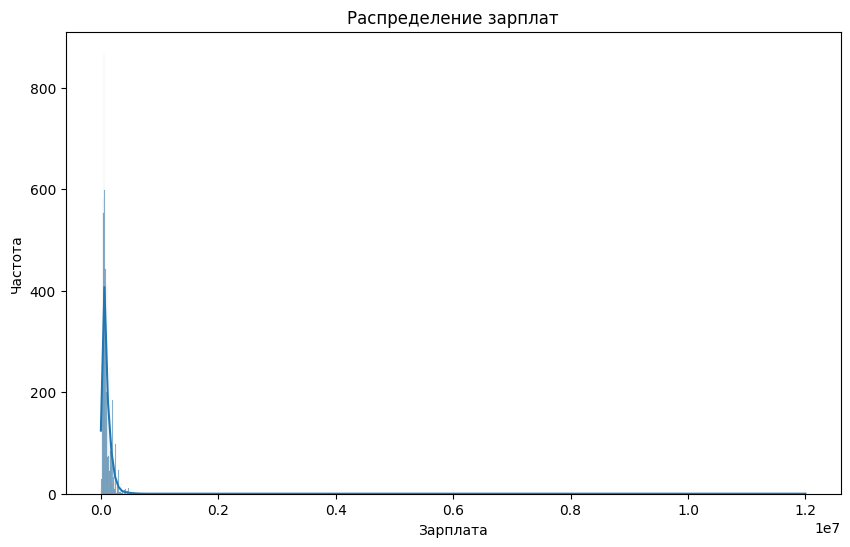

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data['salary'], kde=True)
plt.title('Распределение зарплат')
plt.xlabel('Зарплата')
plt.ylabel('Частота')
plt.show()

    2.3 Зависимость зарплаты от опыта работы

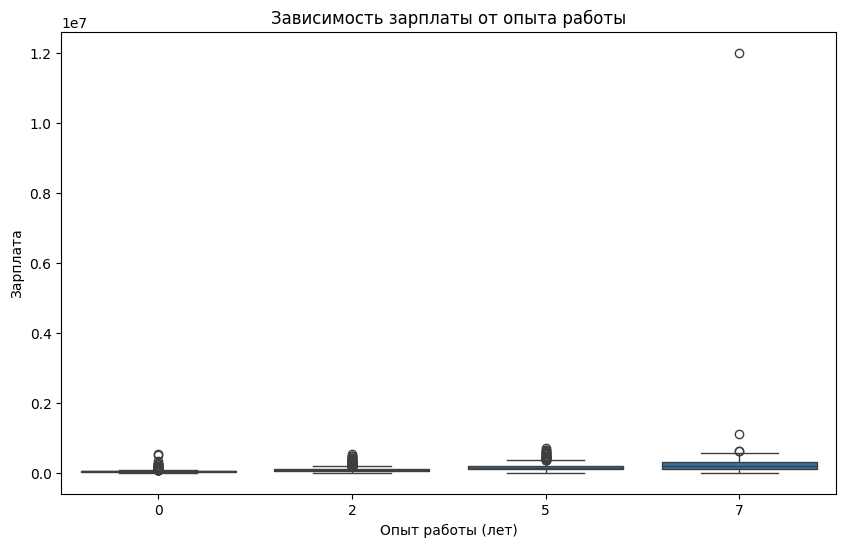

In [70]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='experience', y='salary', data=cleaned_data)
plt.title('Зависимость зарплаты от опыта работы')
plt.xlabel('Опыт работы (лет)')
plt.ylabel('Зарплата')
plt.show()

    2.4 Топ-10 навыков

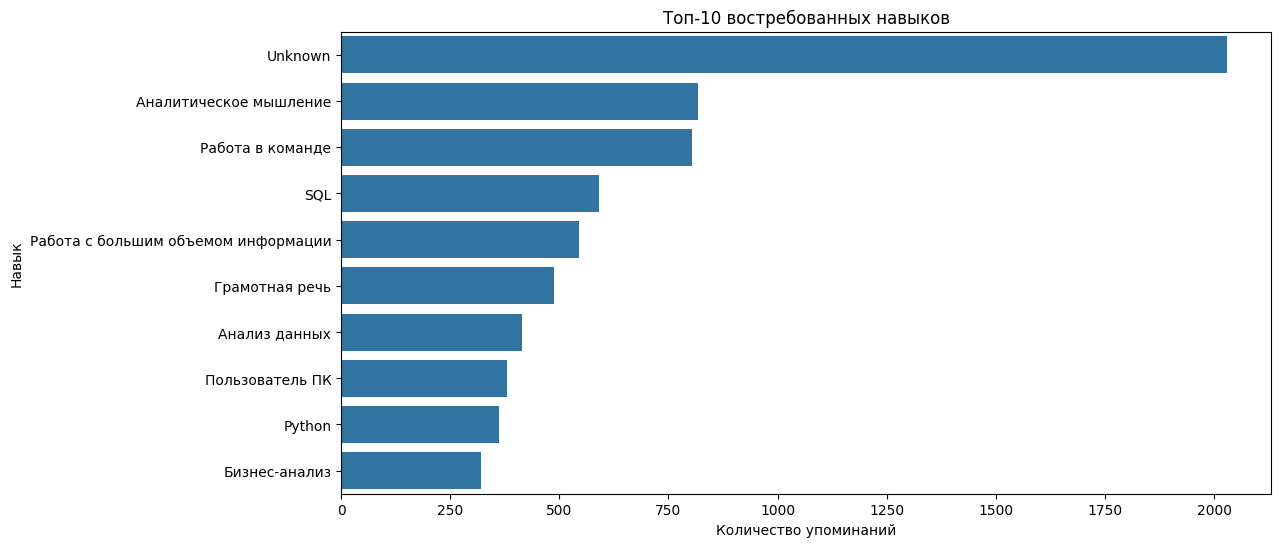

In [71]:
skills = cleaned_data['key_skills'].str.split(',', expand=True).stack()
top_skills = skills.value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_skills.values, y=top_skills.index)
plt.title('Топ-10 востребованных навыков')
plt.xlabel('Количество упоминаний')
plt.ylabel('Навык')
plt.show()

    2.5 Распределение вакансий по городам

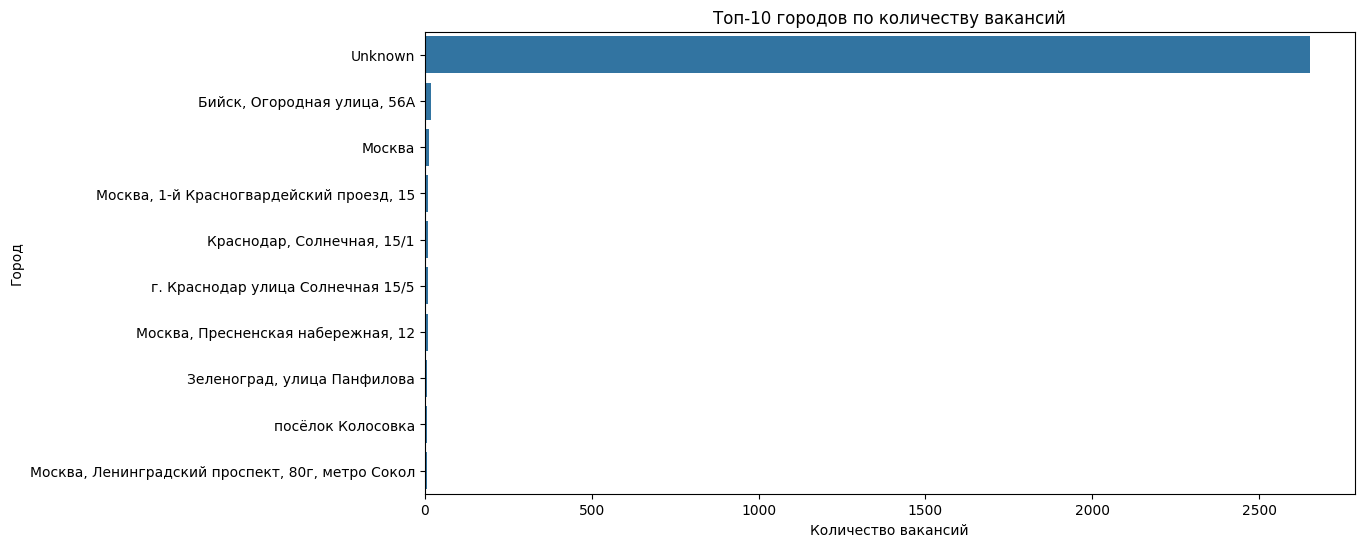

In [72]:
top_cities = cleaned_data['location'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.values, y=top_cities.index)
plt.title('Топ-10 городов по количеству вакансий')
plt.xlabel('Количество вакансий')
plt.ylabel('Город')
plt.show()

3. Подготовка данных для моделирования

In [73]:
# Разделение данных
X = cleaned_data.drop('salary', axis=1)
y = cleaned_data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение типов признаков
numeric_features = ['experience']
categorical_features = ['title', 'job_type', 'location']
text_features = ['key_skills']

# Создание препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', SafeTfidfVectorizer(max_features=100), text_features)
    ])

4. Построение и оценка моделей

    Линейная регрессия (простая модель)

In [74]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

print("Линейная регрессия:")
print(f"MSE: {mean_squared_error(y_test, lr_pred)}")
print(f"R²: {r2_score(y_test, lr_pred)}")
print(f"MAE: {mean_absolute_error(y_test, lr_pred)}")

Линейная регрессия:
MSE: 105468177905.40155
R²: 0.02060231026008008
MAE: 49274.07384756402


    4.2 Случайный лес (простая модель)

In [75]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

print("Случайный лес:")
print(f"MSE: {mean_squared_error(y_test, rf_pred)}")
print(f"R²: {r2_score(y_test, rf_pred)}")
print(f"MAE: {mean_absolute_error(y_test, rf_pred)}")

Случайный лес:
MSE: 105314004902.33842
R²: 0.022033990279770266
MAE: 39412.21194713465


    4.3 XGBoost с оптимизацией гиперпараметров (усложненная модель)


In [76]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 4, 5],
    'regressor__learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
xgb_pred = best_model.predict(X_test)

print("XGBoost (оптимизированный):")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"R²: {r2_score(y_test, xgb_pred)}")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")

C:\Users\ricar\Desktop\MLops\mlops\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ricar\Desktop\MLops\mlops\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ricar\Desktop\MLops\mlops\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ricar\Desktop\MLops\mlops\lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **l

XGBoost (оптимизированный):
Лучшие параметры: {'regressor__learning_rate': 0.3, 'regressor__max_depth': 5, 'regressor__n_estimators': 300}
MSE: 104243312824.8736
R²: 0.031976641873054046
MAE: 41774.378787622016


    5. Анализ результатов

                                     MSE        R²           MAE  \
Линейная регрессия          1.054682e+11  0.020602  49274.073848   
Случайный лес               1.053140e+11  0.022034  39412.211947   
XGBoost (оптимизированный)  1.042433e+11  0.031977  41774.378788   

                            Совокупная метрика  
Линейная регрессия                3.964387e-18  
Случайный лес                     5.308554e-18  
XGBoost (оптимизированный)        7.343019e-18  


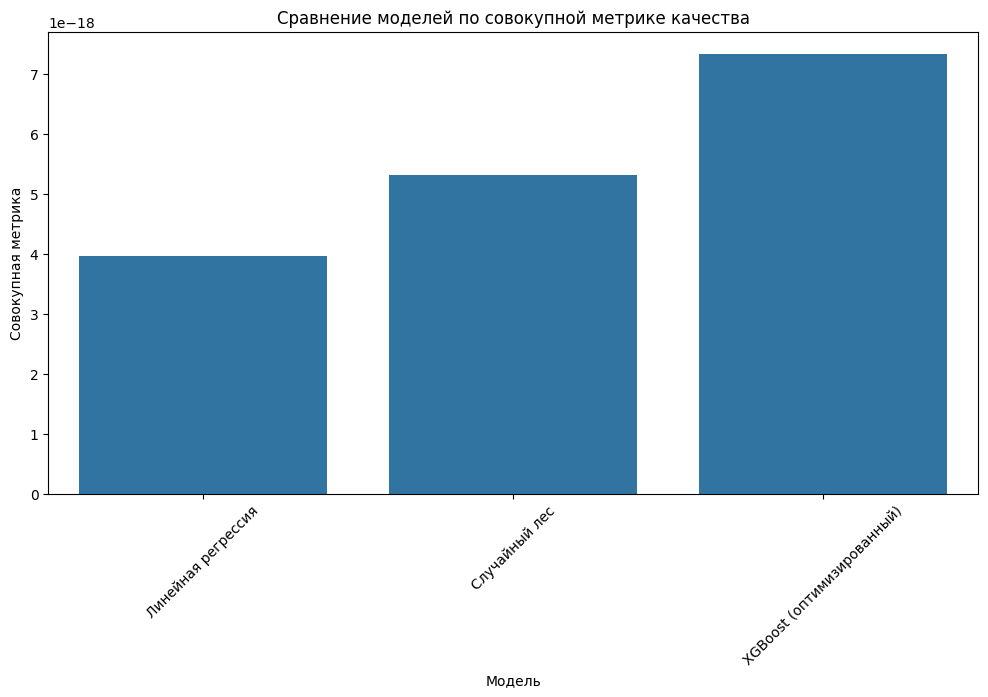

In [77]:
# Функция для расчета совокупной метрики качества
def combined_metric(mse, r2, mae):
    return (1 / mse) * r2 * (1 / mae)

models = {
    'Линейная регрессия': (lr_pred, y_test),
    'Случайный лес': (rf_pred, y_test),
    'XGBoost (оптимизированный)': (xgb_pred, y_test)
}

results = {}

for name, (pred, true) in models.items():
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    combined = combined_metric(mse, r2, mae)
    results[name] = {'MSE': mse, 'R²': r2, 'MAE': mae, 'Совокупная метрика': combined}

results_df = pd.DataFrame(results).T
print(results_df)

# Визуализация результатов
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df['Совокупная метрика'])
plt.title('Сравнение моделей по совокупной метрике качества')
plt.xlabel('Модель')
plt.ylabel('Совокупная метрика')
plt.xticks(rotation=45)
plt.show()

# Выводы по результатам анализа данных о вакансиях

## Сравнение моделей машинного обучения:
- **Оптимизированная модель XGBoost** показала наилучшие результаты среди трех испытанных моделей, с наивысшей совокупной метрикой `7.343019e-18`.
- **Случайный лес** занял второе место с метрикой `5.308554e-18`.
- **Линейная регрессия** показала наихудший результат с метрикой `3.964387e-18`.
- Все модели имеют очень низкие значения R² (0,02-0,03), что указывает на слабую общую предсказательную способность.

## Географическое распределение вакансий:
- Среди известных локаций **Москва** упоминается несколько раз с разными адресами, что указывает на её лидерство по количеству вакансий.
- Другие города (**Бийск**, **Краснодар**, **Зеленоград**) упоминаются редко по сравнению с категорией **"Unknown"**.

## Топ-10 востребованных навыков:
- После категории **"Unknown"**, которая лидирует, самыми востребованными навыками являются:
  1. Аналитическое мышление
  2. Работа в команде
  3. SQL
  4. Работа с большим объемом информации
  5. Грамотная речь

- **Python** входит в топ-10

## Распределение зарплат:
- Распределение зарплат имеет сильную **правостороннюю асимметрию**, с большой концентрацией в нижнем диапазоне.
- Присутствуют выбросы с очень высокими зарплатами, что видно по длинному "хвосту" распределения справа.

## Зависимость зарплаты от опыта работы:
- Наблюдается общая тенденция увеличения зарплаты с ростом опыта работы.
- Разброс зарплат также увеличивается с опытом, что указывает на большую вариативность компенсаций для старших позиций.
- Есть заметные выбросы, особенно в категории с опытом работы более 7 лет.
